In [1]:
import hdf5storage
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
'''this script concate each block per subject to a file wihthin subject called s103_df_concat.csv'''

'''subsequently save a concatenante file under rechain-beh called all_df_concat.csv '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

df = df[df['count'] >=3]
df = df[df['stimDur'] != 0.5]
df = df[df['stimDur'] != 0.05]
cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count'].to_numpy()

/tmp/ipykernel_1541549/3997886365.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_1541549/3997886365.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_1541549/3997886365.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [2]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ..."
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ..."
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ..."
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ..."
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0..."


In [8]:

# calculate terminated chains
cumsum_stop_list = []
binary_seq_all = np.zeros_like(cumsum)
binary_seq_all.fill(np.nan)
for c in range(cumsum.shape[0]):
    binary_seq_all[c, : int(count[c])] = sequence[c, : int(count[c])]
    cumsum_stop = cumsum[
        c, : int(count[c])
    ]  # for example, if rt adjusted i 708, for 250ms, one have seen 3 stimulus.
    cumsum_stop_list.append(cumsum_stop)
 
# count number of NaNs for each chain
nancount = np.isnan(binary_seq_all).sum(axis=1)
    


In [152]:
dataset_resp[30:35]

array([False,  True, False, False, False])

In [157]:
 binary_seq_all[count>=num_of_samples, :][31][29]

nan

In [158]:
sum(count==30)

615

In [290]:
# 
num_of_samples =  10



dataset = binary_seq_all[count>=num_of_samples, :]
dataset_resp = np.isnan(
    dataset[:, num_of_samples]
)  # True means they stopped, false means they kept going
dataset = dataset[:, :num_of_samples]


In [291]:
# size of the samples 
print(len(dataset))

4013


In [292]:
# percentage of termination
dataset_resp.sum() / len(dataset)

0.10416147520558186

In [293]:
# building the classifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



x_train, x_test, y_train, y_test = train_test_split(
    dataset, dataset_resp, test_size=0.3, random_state=1
)

In [294]:
def sigmoid(x, alpha=0.2, beta=0):
    return 1 / (1 + np.exp(-(alpha*x - beta)))

def sigmoid_0(x):
    return 1 / (1 + np.exp(-x))


def get_abs_evidence(x):
    return np.abs(x.cumsum(axis=1))

In [295]:
# tune different coefficient of sigmoid
x_train_evidence = get_abs_evidence(x_train)[:,-1]
x_test_evidence = get_abs_evidence(x_test)[:,-1]

In [296]:
# plot roc


y_pred_prob_train = sigmoid(x_train_evidence)


y_pred_prob_test = sigmoid(x_test_evidence)

fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_pred_prob_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred_prob_test)
auc_train = metrics.auc(fpr_train, tpr_train)
auc_test = metrics.auc(fpr_test, tpr_test)
print(auc_train)
print(auc_test)



0.5580902383266485
0.596084311105948


In [297]:
y_pred_prob_test

array([0.59868766, 0.5       , 0.83201839, ..., 0.59868766, 0.59868766,
       0.5       ])

0.596084311105948


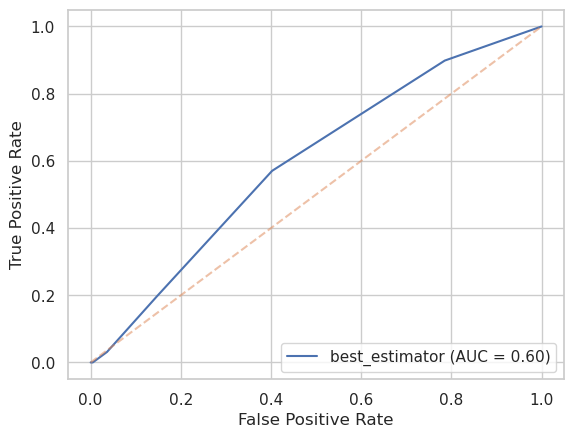

In [299]:
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob_test)
# fpr, tpr, thresh = metrics.roc_curve(y_train, y_pred_prob_train)

roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
fpr
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="best_estimator"
)
display.plot()
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "--", alpha=0.5)
plt.show()